In [193]:
!pip install pmdarima

ent already satisfied: setuptools!=50.0.0,>=38.6.0 in c:\program files\windowsapps\pythonsoftwarefoundation.python.3.9_3.9.496.0_x64__qbz5n2kfra8p0\lib\site-packages (from pmdarima) (49.2.1)
  Running setup.py clean for pmdarima
Failed to build pmdarima
    Running setup.py install for pmdarima: started
    Running setup.py install for pmdarima: finished with status 'error'
  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\marcelo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\marcelo\\AppData\\Local\\Temp\\pip-install-gj2uz9vu\\pmdarima_68dfcaeaad6e4dc2a6fee32b9235b6fe\\setup.py'"'"'; __file__='"'"'C:\\Users\\marcelo\\AppData\\Local\\Temp\\pip-install-gj2uz9vu\\pmdarima_68dfcaeaad6e4dc2a6fee32b9235b6fe\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(co

In [192]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

#from pylab import rcParams 

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import warnings

ModuleNotFoundError: No module named 'pmdarima'

In [3]:
def plotar_grafico(var_data, var_x, var_y, var_title, var_media_movel=""):
    plt.figure(figsize=(15,5))

    sns.lineplot(x=var_x, y=var_y, data=var_data[:50], palette="tab10", linewidth=1.5)

    if var_media_movel != "":
        sns.lineplot(x='Data', y= var_media_movel, data= var_data[:50])

    plt.title(var_title)
    plt.xticks(rotation= 30)
    plt.show()

In [4]:
def plotar_decompose(var_data,var_coluna, var_title, var_model='additive'):
    
    decomposicao =  seasonal_decompose(var_data[var_coluna], model=var_model)

    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,10))

    decomposicao.observed.plot(ax=ax1)
    decomposicao.trend.plot(ax=ax2)
    decomposicao.seasonal.plot(ax=ax3)
    decomposicao.resid.plot(ax=ax4)

    ax1.set_ylabel('Observed')
    ax2.set_ylabel('trend')
    ax3.set_ylabel('seasonal')
    ax4.set_ylabel('resid')

    fig.axes[0].set_title(var_title)

In [5]:
url_file = 'E:/DADOS/Marcelo/Bootcamp/DS/analise_previsao_series_temporais/dados/A105613189_28_143_208.csv'

In [6]:
dados = pd.read_csv(url_file, encoding='ISO-8859-1', sep=';', skiprows=3, skipfooter=16, engine='python')
dados.head()

,Ano Diagnóstico,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez,Total
0,2001,8088,6542,8095,7305,7656,6805,6987,8065,6697,7524,6874,6627,87265
1,2002,8013,7346,7961,8771,7784,6713,7746,8330,7654,8200,7532,6809,92859
2,2003,8115,7985,7474,7975,8024,7082,7949,7585,8136,8521,7624,7303,93773
3,2004,7574,6743,8574,8089,7763,7314,7825,8232,7901,8016,7753,7196,92980
4,2005,7432,6748,8441,7958,8019,7781,7282,8391,7690,7186,7587,7541,92056


In [7]:
dados = dados.drop("Total",axis=1)
dados = dados.drop(19,axis=0)

In [8]:
dados_time_series = dados.melt(id_vars="Ano Diagnóstico", value_name="Casos", var_name="Mes")

dados_time_series['Data'] = dados_time_series["Ano Diagnóstico"] + "-" + dados_time_series["Mes"]


In [9]:
dados_time_series.head()

,Ano Diagnóstico,Mes,Casos,Data
0,2001,Jan,8088,2001-Jan
1,2002,Jan,8013,2002-Jan
2,2003,Jan,8115,2003-Jan
3,2004,Jan,7574,2004-Jan
4,2005,Jan,7432,2005-Jan


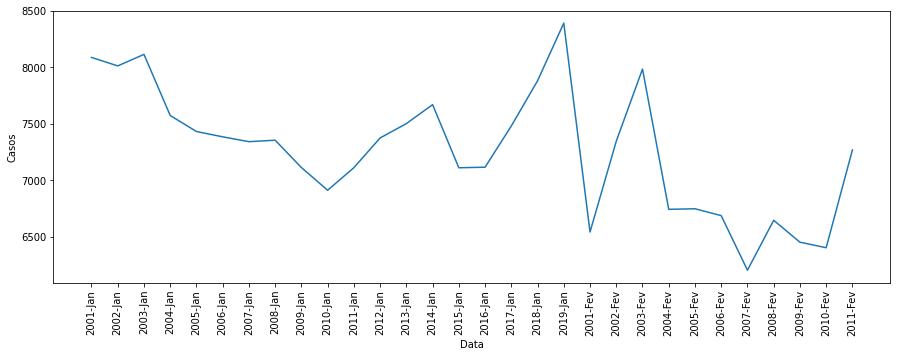

In [10]:
plt.figure(figsize=(15,5))

sns.lineplot(x='Data', y='Casos', data=dados_time_series[:30])

plt.xticks(rotation= 90)
plt.show()

In [11]:
dados_time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Ano Diagnóstico  228 non-null    object
 1   Mes              228 non-null    object
 2   Casos            228 non-null    int64 
 3   Data             228 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.2+ KB


In [12]:
#dados_time_series['data_new'] = dados_time_series['data'].map(str) + '-01'

In [13]:
meses_dict = {'Jan':'Jan',
                'Fev':'Feb',
                'Mar':'Mar',
                'Abr':'Apr',
                'Mai':'May',
                'Jun':'Jun',
                'Jul':'Jul',
                'Ago':'Aug',
                'Set':'Sep',
                'Out':'Oct',
                'Nov':'Nov',
                'Dez':'Dec'}

In [14]:
meses_dict_number = {'Jan':1,
                'Feb':2,
                'Mar':3,
                'Apr':4,
                'May':5,
                'Jun':6,
                'Jul':7,
                'Aug':8,
                'Sep':9,
                'Oct':10,
                'Nov':11,
                'Dec':12}

In [15]:
dados_time_series['Mes'] = dados_time_series['Mes'].map(meses_dict)

In [16]:
dados_time_series.sample(5)

,Ano Diagnóstico,Mes,Casos,Data
86,2011,May,7688,2011-Mai
102,2008,Jun,6929,2008-Jun
187,2017,Oct,7809,2017-Out
179,2009,Oct,7285,2009-Out
13,2014,Jan,7670,2014-Jan


In [17]:
dados_time_series['Data'] = dados_time_series["Ano Diagnóstico"] + "-" + dados_time_series["Mes"]

In [18]:
dados_time_series['Data'] = pd.to_datetime(dados_time_series['Data'])

In [19]:
#dados_time_series['Mes'] = dados_time_series['Data'].map(dados_time_series['Data'].dt.month)

In [20]:
dados_time_series['Mes'] = dados_time_series['Mes'].map(meses_dict_number)


In [21]:
dados_time_series = dados_time_series[['Data','Casos','Mes']]

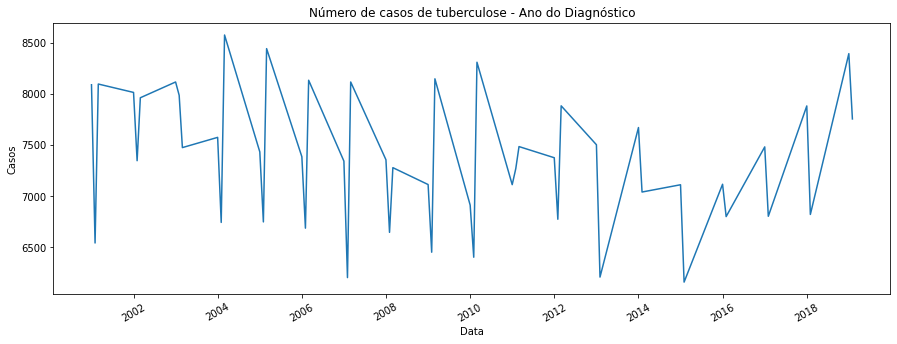

In [22]:
plotar_grafico(dados_time_series, 'Data', 'Casos', 'Número de casos de tuberculose - Ano do Diagnóstico')

In [23]:
#ordenar o dataset pela data
dados_time_series =  dados_time_series.sort_values(by=['Data'])

dados_time_series = dados_time_series.reset_index(drop= True)

In [24]:
dados_time_series.head()

,Data,Casos,Mes
0,2001-01-01,8088,1
1,2001-02-01,6542,2
2,2001-03-01,8095,3
3,2001-04-01,7305,4
4,2001-05-01,7656,5


In [25]:
dados_time_series['MM_3'] = dados_time_series['Casos'].rolling(3).mean()

In [26]:
dados_time_series['MM_6'] = dados_time_series['Casos'].rolling(6).mean()

In [27]:
dados_time_series['MM_3c'] = dados_time_series['Casos'].rolling(3, center= True).mean()

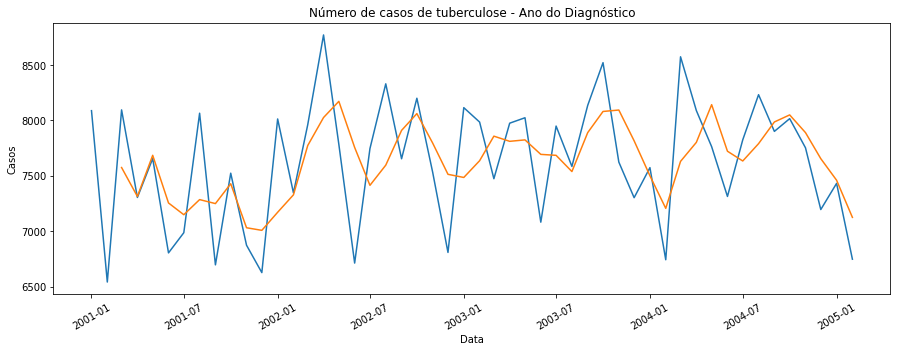

In [28]:
plotar_grafico(dados_time_series, 'Data', 'Casos', 'Número de casos de tuberculose - Ano do Diagnóstico','MM_3')

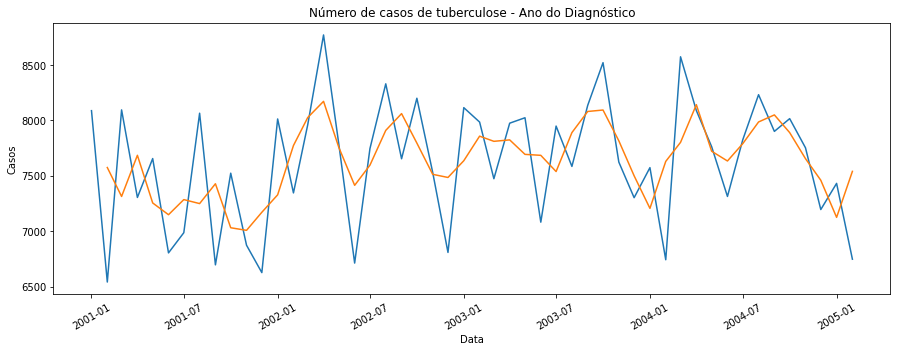

In [29]:
plotar_grafico(dados_time_series, 'Data', 'Casos', 'Número de casos de tuberculose - Ano do Diagnóstico','MM_3c')

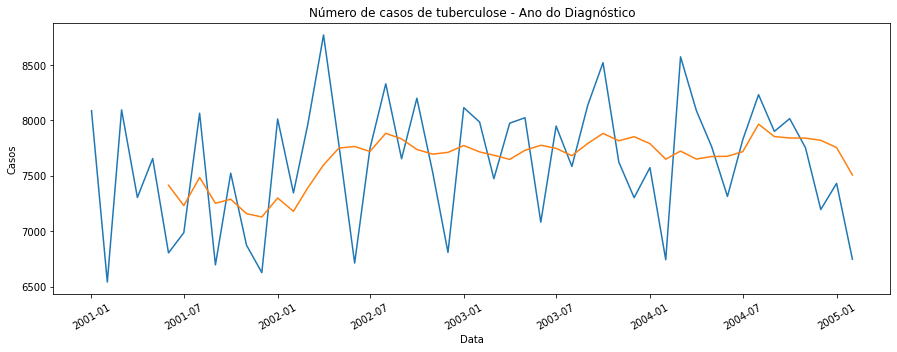

In [30]:
plotar_grafico(dados_time_series, 'Data', 'Casos', 'Número de casos de tuberculose - Ano do Diagnóstico','MM_6')

<AxesSubplot:xlabel='Data', ylabel='Casos'>

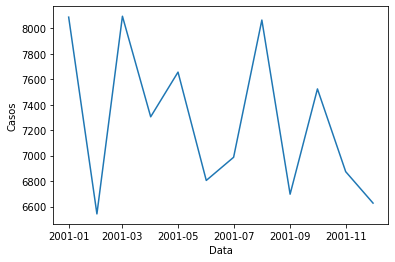

In [31]:
sns.lineplot(x='Data', y='Casos', data=dados_time_series[:12])

<AxesSubplot:xlabel='Data', ylabel='Casos'>

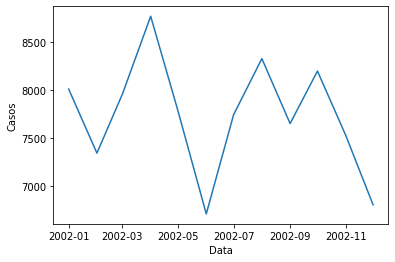

In [32]:
sns.lineplot(x='Data', y='Casos', data=dados_time_series[12:24])

In [33]:
dados_time_series['Ano'] = dados_time_series['Data'].dt.year
dados_time_series['Mes'] = dados_time_series['Data'].dt.month


<AxesSubplot:xlabel='Mes', ylabel='Casos'>

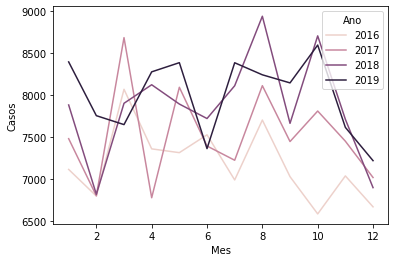

In [34]:
sns.lineplot(x='Mes', y='Casos', data=dados_time_series.query("Ano in[2019,2018,2017,2016]"), hue='Ano')

In [35]:
dados_time_series = dados_time_series.set_index('Data')

In [36]:
dados_time_series

,Casos,Mes,MM_3,MM_6,MM_3c,Ano
Data,,,,,,
2001-01-01,8088,1,NaN,NaN,NaN,2001
2001-02-01,6542,2,NaN,NaN,7575.000000,2001
2001-03-01,8095,3,7575.000000,NaN,7314.000000,2001
2001-04-01,7305,4,7314.000000,NaN,7685.333333,2001
2001-05-01,7656,5,7685.333333,NaN,7255.333333,2001
...,...,...,...,...,...,...
2019-08-01,8239,8,7994.666667,8048.166667,8254.666667,2019
2019-09-01,8143,9,8254.666667,8130.666667,8324.666667,2019
2019-10-01,8592,10,8324.666667,8183.666667,8116.666667,2019


In [104]:
decomposicao =  seasonal_decompose(dados_time_series['Casos'])

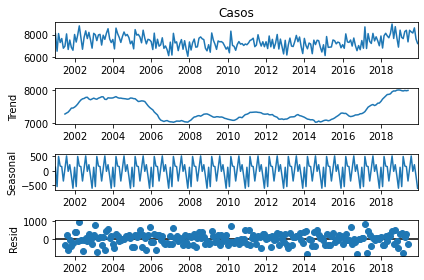

In [68]:
decomposicao.plot();


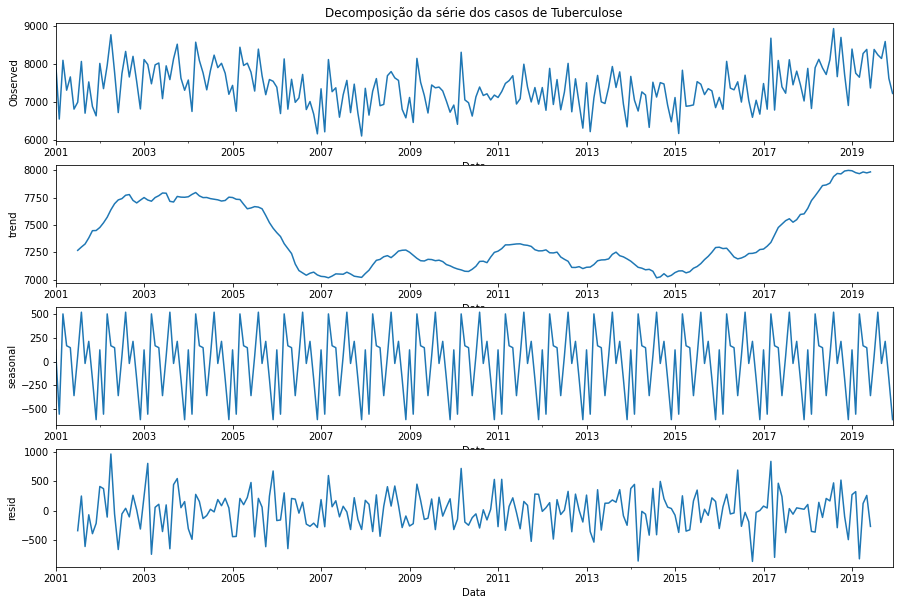

In [39]:
plotar_decompose(dados_time_series,'Casos','Decomposição da série dos casos de Tuberculose')

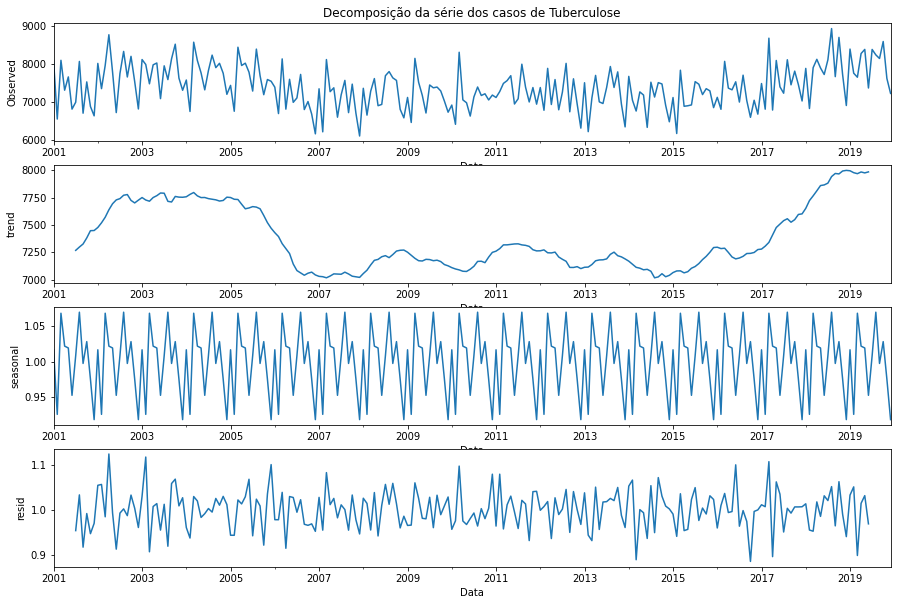

In [40]:
plotar_decompose(dados_time_series,'Casos', 'Decomposição da série dos casos de Tuberculose', 'multiplicative')

In [87]:
url_passageiros = 'E:/DADOS/Marcelo/Bootcamp/DS/analise_previsao_series_temporais/dados/AirPassengers.csv'
dados_passengers = pd.read_csv(url_passageiros)
dados_passengers['Month'] =  pd.to_datetime(dados_passengers['Month'])
dados_passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


<AxesSubplot:xlabel='Month', ylabel='#Passengers'>

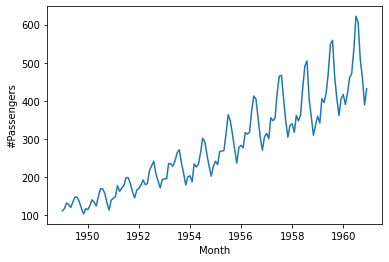

In [88]:
sns.lineplot(x ='Month', y ='#Passengers', data = dados_passengers)

In [89]:
dados_passengers

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [90]:
dados_passengers = dados_passengers.set_index('Month')


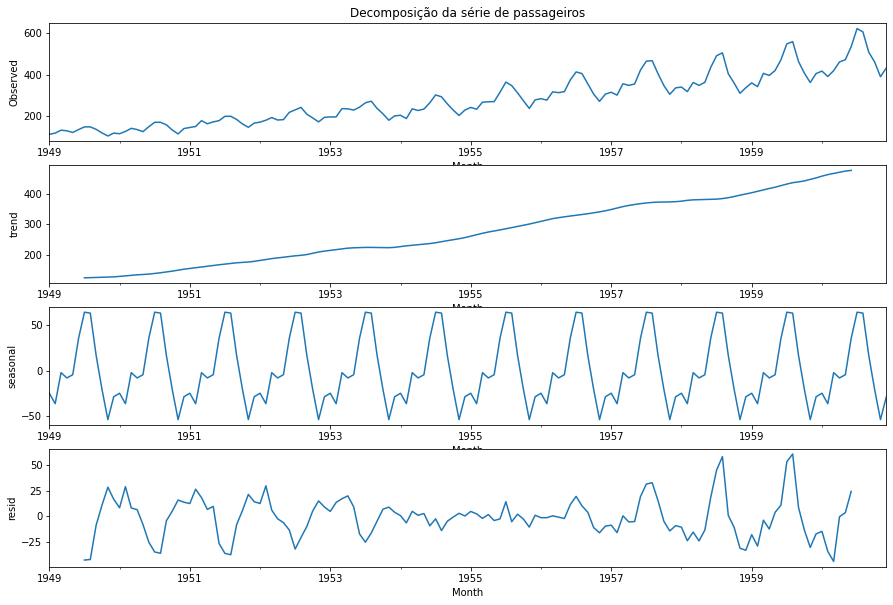

In [91]:
decomposicao_p =  seasonal_decompose(dados_passengers['#Passengers'])
#decomposicao.plot();

plotar_decompose(dados_passengers,'#Passengers', 'Decomposição da série de passageiros')

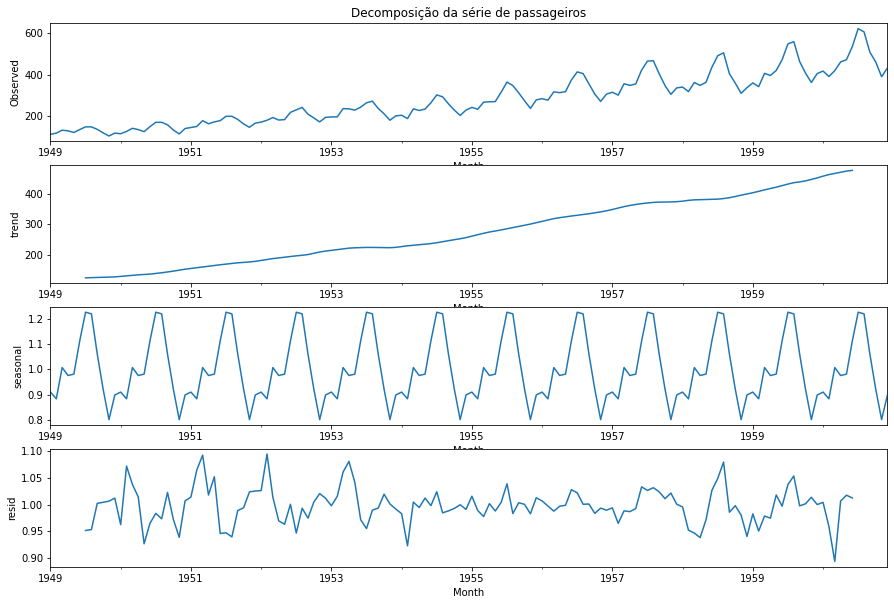

In [92]:
decomposicao_p =  seasonal_decompose(dados_passengers['#Passengers'], model='multiplicative')
#decomposicao.plot(2);


plotar_decompose(dados_passengers,'#Passengers', 'Decomposição da série de passageiros', 'multiplicative')

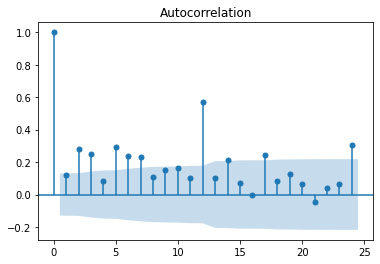

In [93]:
plot_acf(dados_time_series['Casos']);

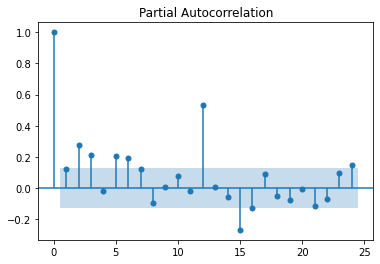

In [78]:
plot_pacf(dados_time_series['Casos']);

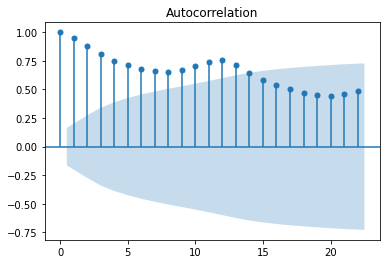

In [94]:
plot_acf(dados_passengers['#Passengers']);


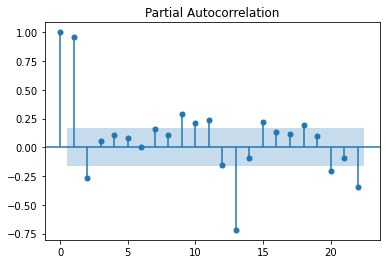

In [95]:
plot_pacf(dados_passengers['#Passengers']);

In [96]:
dados_passengers.reset_index(inplace=True)
dados_passengers.rename({'Month':'Data', '#Passengers':'Passageiros'}, axis=1, inplace=True)

In [97]:
dados_passengers['Mes'] = dados_passengers['Data'].dt.month
dados_passengers['Ano'] = dados_passengers['Data'].dt.year

<AxesSubplot:xlabel='Mes', ylabel='Passageiros'>

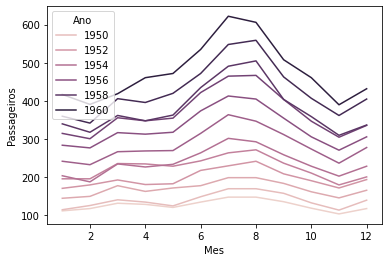

In [98]:
sns.lineplot(x='Mes', y='Passageiros', data= dados_passengers, hue='Ano')

<AxesSubplot:xlabel='Month'>

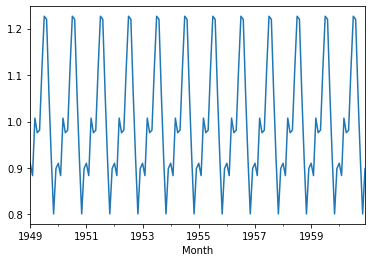

In [100]:
decomposicao_p.seasonal.plot()

<AxesSubplot:xlabel='Month'>

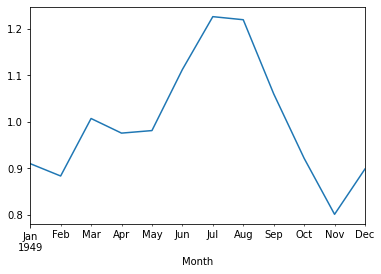

In [103]:
decomposicao_p.seasonal[:12].plot()

<AxesSubplot:xlabel='Data'>

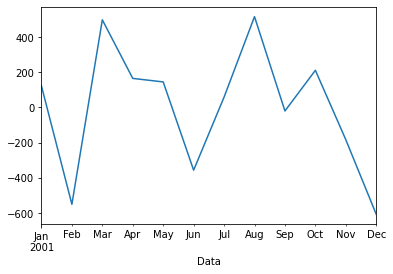

In [105]:
decomposicao.seasonal[:12].plot()

In [125]:
modelo_arima = ARIMA(dados_time_series['Casos'].values.astype('float32'), order=[0,0,0])
modelo_arima_treinado = modelo_arima.fit()

In [123]:
modelo_arima_treinado

In [130]:
modelo_arima_treinado.forecast(12)[0]

array([7355.33333467, 7355.33333467, 7355.33333467, 7355.33333467,
       7355.33333467, 7355.33333467, 7355.33333467, 7355.33333467,
       7355.33333467, 7355.33333467, 7355.33333467, 7355.33333467])

In [158]:
dados_treino = dados_time_series.query("Ano != 2019")
dados_teste = dados_time_series.query('Ano == 2019')

In [189]:
modelo_arima = ARIMA(dados_treino['Casos'].values.astype('float32'), order=[12,1,2])#Autoregressivo order=[1,0,0], média mvel   ordem 1 order=[0,0,1]
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(12)[0]

<AxesSubplot:xlabel='Data', ylabel='Casos'>

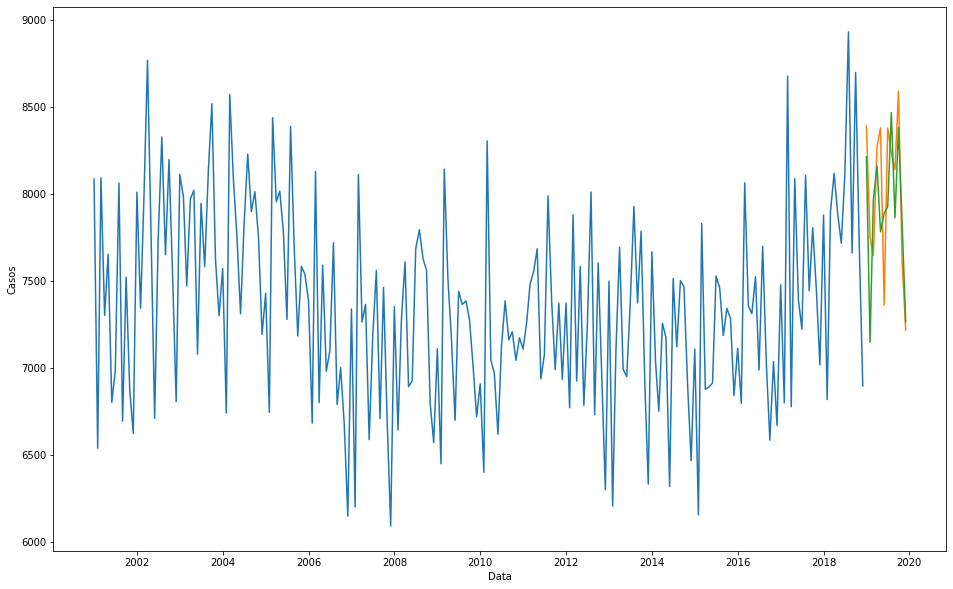

In [190]:
dados_teste['Previsao'] = previsao
plt.figure(figsize=(16,10))
sns.lineplot(x='Data', y='Casos', data= dados_treino)
sns.lineplot(x='Data', y='Casos', data= dados_teste)
sns.lineplot(x='Data', y='Previsao', data= dados_teste)


In [168]:
dados_treino_passageiros = dados_passengers.query("Ano != 1960")
dados_teste_passageiros = dados_passengers.query('Ano == 1960')

In [183]:
modelo_arima = ARIMA(dados_treino_passageiros['Passageiros'].values.astype('float32'), order=[2,1,2])#Autoregressivo order=[1,0,0], média mvel   ordem 1 order=[0,0,1]
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(12)[0]

<AxesSubplot:xlabel='Data', ylabel='Passageiros'>

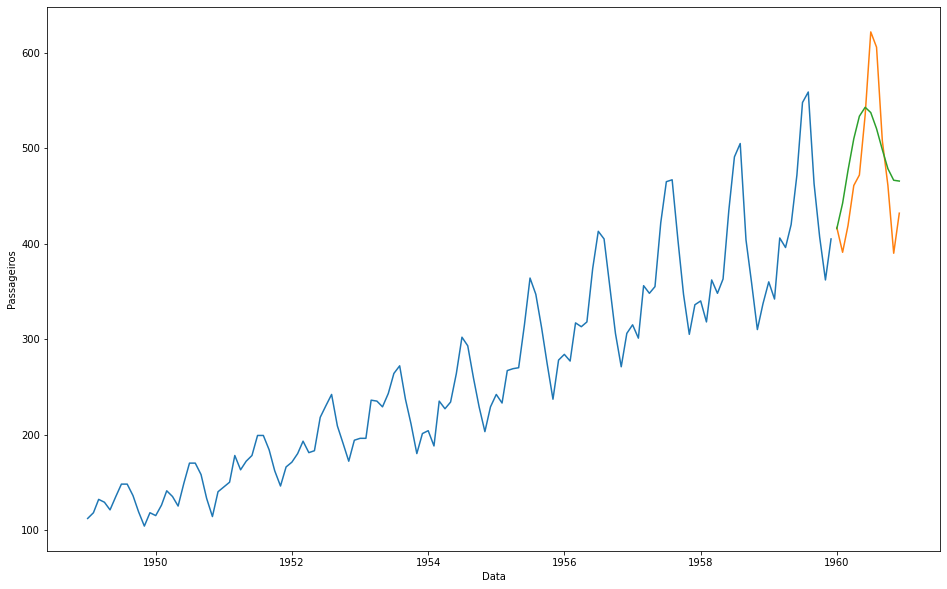

In [184]:
dados_teste_passageiros['Previsao'] = previsao
plt.figure(figsize=(16,10))
sns.lineplot(x='Data', y='Passageiros', data= dados_treino_passageiros)
sns.lineplot(x='Data', y='Passageiros', data= dados_teste_passageiros)
sns.lineplot(x='Data', y='Previsao', data= dados_teste_passageiros)

In [101]:
dados_passengers

,Data,Passageiros,Mes,Ano
0,1949-01-01,112,1,1949
1,1949-02-01,118,2,1949
2,1949-03-01,132,3,1949
3,1949-04-01,129,4,1949
4,1949-05-01,121,5,1949
...,...,...,...,...
139,1960-08-01,606,8,1960
140,1960-09-01,508,9,1960
141,1960-10-01,461,10,1960
142,1960-11-01,390,11,1960


## Desafio 01: Transformar os dados em uma série temporal: ANO-MES

## Desafio 02: Converter a coluna data para o tipo datetime

## Desafio 03: Realizar os mesmos processos de transformação dos dados para a base de dados de Hanseníase

## Desafio 04: Deixar o gráfico da série temporal visualmente melhor

## Desafio 05: Analisar outras janelas para média móvel.

## Desafio 06: Realizar sua primeira previsão utilizando médias( toda a série, 3 últimos meses)

In [ ]:
dados_time_series.tail(1)

In [ ]:
media_total =  dados_time_series.tail(1) #dados_time_series.copy()
media_total = media_total.append({'Data': '2020-01-01', 'Casos': dados_time_series['Casos'].mean()}, ignore_index=True)
media_total['Data'] = pd.to_datetime(media_total['Data'])
media_total

In [ ]:
dados_time_series2 = dados_time_series.copy()
dados_time_series2['Casos_Ultimo_Mes'] = dados_time_series2['Casos'].shift()
dados_time_series2['Diff_Casos_Ultimo_Mes'] = dados_time_series2['Casos_Ultimo_Mes'].diff()
dados_time_series2 = dados_time_series2.dropna()
dados_time_series2.head()

In [ ]:
dados_time_series2.tail()

In [ ]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [ ]:
#dados_time_series2.query('Data >= "2019-09-01"')['Mes']
dados_time_series2.query('Data >= "2019-08-01"')[dados_time_series2['Mes'] < month]

In [ ]:
mean_error = []
for month in range(9,12):
    train = dados_time_series2.query('Data >= "2019-08-01"')[dados_time_series2['Mes'] < month]
    val = dados_time_series2.query('Data >= "2019-08-01"')[dados_time_series2['Mes'] == month]
    
    p = val['Casos_Ultimo_Mes'].values
    
    error = rmsle(val['Casos'].values, p)
    print('Mes %d - Erro %.5f' % (month, error))
    mean_error.append(error)
print('Média Erro = %.5f' % np.mean(mean_error))

In [ ]:
train

In [ ]:
val

In [ ]:
plt.figure(figsize=(15,5))

sns.lineplot(x='Data', y='Casos', data=dados_time_series, palette="tab10", linewidth=1.5)
plt.plot(media_total.Data, media_total.Casos, 'r--')

plt.title('Previsão do próximo mês com uso de médias móveis - Pela média total')
plt.xticks(rotation= 30)
plt.show()

In [ ]:
media = dados_time_series['Casos'].tail(3).mean()

media_ultimos_meses = dados_time_series.tail(1)
media_ultimos_meses = media_ultimos_meses.append({'Data': '2020-01-01', 'Casos': media}, ignore_index=True)
media_ultimos_meses['Data'] = pd.to_datetime(media_ultimos_meses['Data'])
media_ultimos_meses

In [ ]:
plt.figure(figsize=(15,5))

sns.lineplot(x='Data', y='Casos', data=dados_time_series, palette="tab10", linewidth=1.5)
plt.plot(media_ultimos_meses.Data, media_ultimos_meses.Casos, 'r--')

plt.title('Previsão do próximo mês com uso de médias móveis - Últimos 3 mêses')
plt.xticks(rotation= 30)
plt.show()

## Desafio 07: Transformar as datas em index e realizar os slices pelas datas

## Desafio 08: Formatar os gráficos de decomposição, colocar título e modificar os tamanhos. Realizar a decomposição de outras séries temporais.

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposicao =  seasonal_decompose(dados_passengers['#Passengers'])
fig = decomposicao.plot()
fig.axes[0].set_title('Decomposição da série de passageiros.')

plt.show()

## Desafio 09: Realizar uma análise de autocorrelação e autocorrelação parcial dos dados de COVID-19

## Desafio 10: Na tupla de retorno do forecast, estudar o que são os elementos 1 e 2.

## Desafio 11: Utilizar o ARIMA para a base de dados passageiros e modificar os parâmetros order.

In [147]:
dados_passengers

,Data,Passageiros,Mes,Ano
0,1949-01-01,112,1,1949
1,1949-02-01,118,2,1949
2,1949-03-01,132,3,1949
3,1949-04-01,129,4,1949
4,1949-05-01,121,5,1949
...,...,...,...,...
139,1960-08-01,606,8,1960
140,1960-09-01,508,9,1960
141,1960-10-01,461,10,1960
142,1960-11-01,390,11,1960


<AxesSubplot:xlabel='Data', ylabel='Passageiros'>

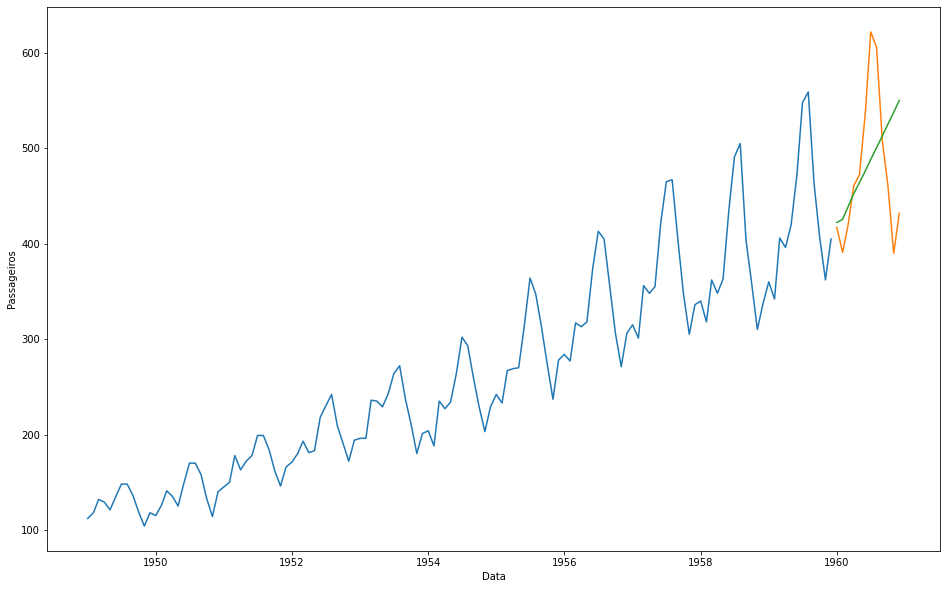

In [157]:
dados_treino = dados_passengers.query("Ano != 1960")
dados_teste = dados_passengers.query('Ano == 1960')

modelo_arima = ARIMA(dados_treino['Passageiros'].values.astype('float32'), order=[2,2,0])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(12)[0]

dados_teste['Previsao'] = previsao
plt.figure(figsize=(16,10))
sns.lineplot(x='Data', y='Passageiros', data= dados_treino)
sns.lineplot(x='Data', y='Passageiros', data= dados_teste)
sns.lineplot(x='Data', y='Previsao', data= dados_teste)


## Desafio 12: Visualizar as séries temporias diferenciadas (Dicas dii pandas)